In [1]:
import os
import pandas as pd
import geopandas as gpd

local_crs = 32636
example_data_path = "./data"

In [2]:
from masterplan_tools.models import City
city_model = City.from_pickle(os.path.join(example_data_path, 'city_model.pickle'))

In [3]:
city_model.service_types

[ServiceType(name='kindergartens', accessibility=10, demand=61, buffer=15),
 ServiceType(name='schools', accessibility=15, demand=120, buffer=0),
 ServiceType(name='recreational_areas', accessibility=15, demand=6000, buffer=0),
 ServiceType(name='hospitals', accessibility=60, demand=9, buffer=0),
 ServiceType(name='pharmacies', accessibility=10, demand=50, buffer=0),
 ServiceType(name='policlinics', accessibility=15, demand=27, buffer=0)]

In [4]:
from masterplan_tools.method import Provision
prov = Provision(city_model=city_model)
calc = prov.calculate('kindergartens')

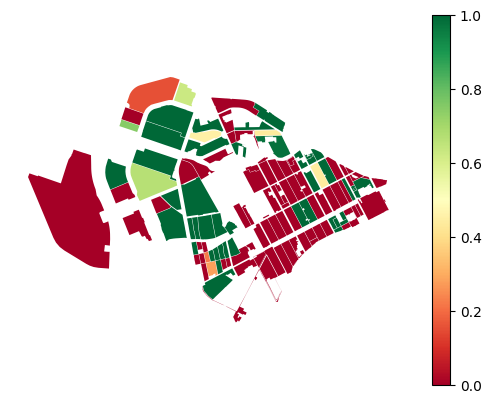

In [5]:
prov.plot(calc)